In [ ]:
# Import required libraries
import random
import pickle 
import gzip
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# To load MNIST data
def load_data():
  """" Training Data ------------------------> tuple with 2 entries with 50,000 entries
                                               first entry is training images which is numpy ndarray of 784 values (28*28)
                                               second entry is digit value (0 to 9) corresponding to the image in first entry

       Validation and Test Data -------------> Its similar to training data except each with 10,000 entries"""

  file = gzip.open('mnist.pkl.gz', 'rb')
  training_data, validation_data, test_data = pickle.load(file,encoding='latin1')
  file.close()
  return (training_data, validation_data, test_data)

def data_loader():
  """ Returns a tuple containing training data, validation data and test data
      Training data --------------------> converted into the list of tuples (x,y) with 50,000 entries
                                          x is numpy ndarray of 784 values and y is numpy ndarray of 10 values which is a unit vector
                                          corresponding to the digit x
      Validation and Test data ---------> converted into the list of tuples (x,y) with 50,000 entries each
                                          first entry is training images which is numpy ndarray of 784 values (28*28)
                                          second entry is digit value (0 to 9) corresponding to the image in first entry """
  train_d, val_d, test_d = load_data()
  train_inputs = [np.reshape(x, (784, 1)) for x in train_d[0]]
  train_outputs = [vectorized_output(y) for y in train_d[1]]
  training_data = zip(train_inputs, train_outputs)
  val_inputs = [np.reshape(x, (784, 1)) for x in val_d[0]]
  validation_data = zip(val_inputs, val_d[1])
  test_inputs = [np.reshape(x, (784, 1)) for x in test_d[0]]
  test_data = zip(test_inputs, test_d[1])
  return (training_data, validation_data, test_data)

def vectorized_output(i):
  """ Returns a unit vector with a 1.0 at i^th position"""
  v = np.zeros((10, 1))
  v[i] = 1.0
  return v

# Equations used in backpropogation:

\begin{eqnarray} 
  \delta^L_j = \frac{\partial C}{\partial a^L_j} \sigma'(z^L_j)
\end{eqnarray}
\begin{eqnarray} 
  \delta^L = (a^L-y) \odot \sigma'(z^L)
\end{eqnarray}
\begin{eqnarray} 
  \delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l)
\end{eqnarray}
\begin{eqnarray}  \frac{\partial C}{\partial b^l_j} =
  \delta^l_j
\end{eqnarray}
\begin{eqnarray}
  \frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j
\end{eqnarray}


In [ ]:
class NeuralNet(object):

  def __init__(self, sizes):
    """ sizes ----> list of no. of neurons in each layer,
        Initialize weights and biases"""
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]             

  def feedforward(self, a):
    """computes output of the network """
    for b, w in zip(self.biases, self.weights):
      a = sigmoid(np.dot(w, a)+b)   
    return a

  def Katyusha(self, training_data, epochs, L,
            test_data=None): 
    """Training algorithm for training the neural net,
       L is a Lipschitz constant"""        
    training_data = list(training_data)
    n = len(training_data)
    m = 2*n
    tau_2 = 0.5
    
    if test_data:
        test_data = list(test_data)
        n_test = len(test_data)
    training_cost = []    
    test_accuracy = []
    weights = self.weights.copy()
    biases = self.biases.copy()

    # Initializing x_k, y_k , z_k 
    x_w = np.array(weights)
    y_w = x_w.copy()
    z_w = x_w.copy()
    
    x_b = np.array(biases)
    y_b = x_b.copy()
    z_b = x_b.copy()
    
    for S in range(epochs):
      tau_1 = 2/(S+4)
      alpha = 1/(3*tau_1*L)

      random.shuffle(training_data)
      #compute the full gradient with respect to weights and biases
      g_b, g_w = self.full_grad(training_data, self.weights, self.biases)
      mu_s_w = (1/n)*np.array(g_w)
      mu_s_b = (1/n)*np.array(g_b)
      
      # Initialize x^s_tilda
      x_w_tilda = np.array(self.weights)
      x_b_tilda = np.array(self.biases)

      b = np.array([np.zeros(w.shape) for w in self.weights])
      c = np.array([np.zeros(b.shape) for b in self.biases])

      for j in range(m):
        # compute x_k
        x_w = (tau_1*z_w) + (tau_2*x_w_tilda) + ((1-tau_1-tau_2)*y_w)
        x_b = (tau_1*z_b) + (tau_2*x_b_tilda) + ((1-tau_1-tau_2)*y_b)
        for i in range(len(weights)):
          weights[i] = x_w[i]
        for i in range(len(biases)):
          biases[i] = x_b[i] 

        p, q = random.choice(training_data)

        # compute sample gradient w.r.t. x_k 
        nabla_p,nabla_q = self.sample_grad(p, q, weights, biases)
        # compute sample gradient w.r.t x^s_tilda
        nabla_r,nabla_s = self.sample_grad(p, q, self.weights, self.biases)
        
        # compute gradient estimator
        grad_w = mu_s_w + np.array(nabla_q) - np.array(nabla_s)
        grad_b = mu_s_b + np.array(nabla_p) - np.array(nabla_r)

        # Update y_k and z_k
        y_w = x_w - (1/(3*L))*grad_w
        y_b = x_b - (1/(3*L))*grad_b
        z_w =  z_w - (alpha*grad_w)
        z_b =  z_b - (alpha*grad_b)
        
        # Compute sum of recent y_k 
        b = b + y_w
        c = c + y_b
    
      # Compute x^s_tilda as avg. of recent y_k
      avg_w = (1/m)*b
      avg_b = (1/m)*c

     # Update x^s_tilda i.e. weights and biases
      for i in range(len(self.weights)):
        self.weights[i] = avg_w[i]
      for i in range(len(self.biases)):
        self.biases[i] = avg_b[i]



      cost = self.total_cost(training_data)
      training_cost.append(cost)
      if test_data:
              print("Epoch {} : {} / {}".format(S,self.evaluate(test_data),n_test));
              accuracy = self.evaluate(test_data)/len(test_data)
              test_accuracy.append(accuracy)
      else:
              print("Epoch {} complete".format(S))
    return training_cost , test_accuracy    


  def full_grad(self,training_data, weights, biases):
    """ Returns full gradient w.r.t to biases and weights"""
    gradient_b = [np.zeros(b.shape) for b in biases]
    gradient_w = [np.zeros(w.shape) for w in weights]
    for x, y in training_data:
      delta_b, delta_w = self.backprop(x, y, weights, biases)
      gradient_b = [g_b+d_b for g_b, d_b in zip(gradient_b, delta_b)]
      gradient_w = [g_w+d_w for g_w, d_w in zip(gradient_w, delta_w)]
    return (gradient_b,gradient_w)  

  def sample_grad(self, x, y, weight, bias):
    """ Returns sample gradient w.r.t to biases and weights"""
    gi_b , gi_w = self.backprop(x, y, weight, bias)
    return (gi_b, gi_w)



  def backprop(self, x, y, weights, biases):
    """calculates gradient of cost function with respect to weights and biases"""
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    activation = x
    activations = [x]
    zs = []
    for b, w in zip(biases, weights):
      z = np.dot(w, activation)+b
      zs.append(z)
      activation = sigmoid(z)
      activations.append(activation)
    delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    for l in range(2, self.num_layers):
      z = zs[-l]
      sp = sigmoid_prime(z)
      delta = np.dot(weights[-l+1].transpose(), delta) * sp
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)

  def evaluate(self, test_data):
    """Returns the number of test inputs which are correctly classified by
    the neural network"""
    test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)

  def total_cost(self,data):
    """computs the training cost"""
    c=0.0
    for x,y in data:
      a = self.feedforward(x)
      c += (0.5*np.linalg.norm(a-y)**2)/len(data)
    return c  

  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

 
def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))   
def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

                                                        

In [ ]:
training_data, validation_data, test_data = data_loader()

In [ ]:
training_data = list(training_data)
print(len(training_data))
m, n = random.choice(training_data)
print(n)

50000
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
net = NeuralNet([784, 30, 10])

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [ ]:
training_cost,test_accuracy = net.Katyusha(training_data, 50, 20,
            test_data=test_data)

Epoch 0 : 3679 / 10000
Epoch 1 : 7049 / 10000
Epoch 2 : 7700 / 10000
Epoch 3 : 7923 / 10000
Epoch 4 : 8054 / 10000
Epoch 5 : 8126 / 10000
Epoch 6 : 8161 / 10000
Epoch 7 : 8860 / 10000
Epoch 8 : 9283 / 10000
Epoch 9 : 9316 / 10000
Epoch 10 : 9356 / 10000
Epoch 11 : 9373 / 10000
Epoch 12 : 9391 / 10000
Epoch 13 : 9407 / 10000
Epoch 14 : 9413 / 10000
Epoch 15 : 9413 / 10000
Epoch 16 : 9402 / 10000
Epoch 17 : 9402 / 10000
Epoch 18 : 9407 / 10000
Epoch 19 : 9413 / 10000
Epoch 20 : 9412 / 10000
Epoch 21 : 9414 / 10000
Epoch 22 : 9406 / 10000
Epoch 23 : 9407 / 10000
Epoch 24 : 9406 / 10000
Epoch 25 : 9407 / 10000
Epoch 26 : 9404 / 10000
Epoch 27 : 9400 / 10000
Epoch 28 : 9402 / 10000
Epoch 29 : 9405 / 10000
Epoch 30 : 9407 / 10000
Epoch 31 : 9416 / 10000
Epoch 32 : 9421 / 10000
Epoch 33 : 9419 / 10000
Epoch 34 : 9418 / 10000
Epoch 35 : 9410 / 10000
Epoch 36 : 9415 / 10000
Epoch 37 : 9417 / 10000
Epoch 38 : 9422 / 10000
Epoch 39 : 9422 / 10000
Epoch 40 : 9419 / 10000
Epoch 41 : 9418 / 10000
Ep

Text(0, 0.5, 'accuracy')

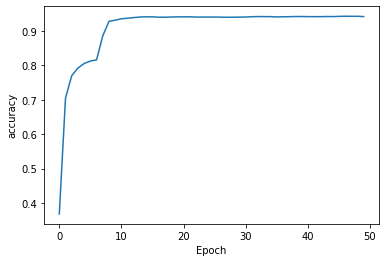

In [ ]:
plt.plot(test_accuracy)
plt.xlabel('Epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'cost')

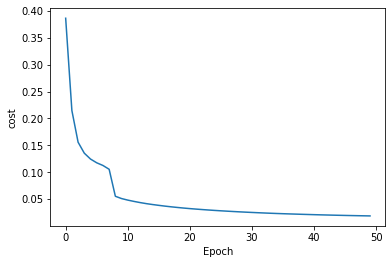

In [ ]:
plt.plot(training_cost)
plt.xlabel('Epoch')
plt.ylabel('cost')

In [ ]:

training_cost_1,test_accuracy_1 = net.Katyusha(training_data, 30, 20,
            test_data=test_data)

Epoch 0 : 6039 / 10000
Epoch 1 : 7830 / 10000
Epoch 2 : 8747 / 10000
Epoch 3 : 8957 / 10000
Epoch 4 : 9075 / 10000
Epoch 5 : 9124 / 10000
Epoch 6 : 9192 / 10000
Epoch 7 : 9229 / 10000
Epoch 8 : 9258 / 10000
Epoch 9 : 9273 / 10000
Epoch 10 : 9298 / 10000
Epoch 11 : 9307 / 10000
Epoch 12 : 9323 / 10000
Epoch 13 : 9330 / 10000
Epoch 14 : 9342 / 10000
Epoch 15 : 9354 / 10000
Epoch 16 : 9351 / 10000
Epoch 17 : 9355 / 10000
Epoch 18 : 9354 / 10000
Epoch 19 : 9356 / 10000
Epoch 20 : 9366 / 10000
Epoch 21 : 9370 / 10000
Epoch 22 : 9377 / 10000
Epoch 23 : 9379 / 10000
Epoch 24 : 9383 / 10000
Epoch 25 : 9388 / 10000
Epoch 26 : 9391 / 10000
Epoch 27 : 9395 / 10000
Epoch 28 : 9404 / 10000
Epoch 29 : 9407 / 10000


Text(0, 0.5, 'accuracy')

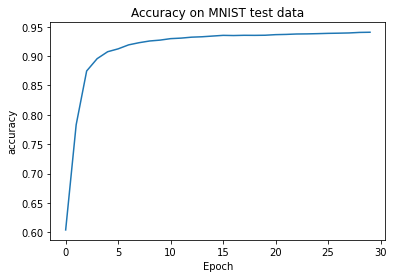

In [ ]:
plt.plot(test_accuracy_1)
plt.title('Accuracy on MNIST test data')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'cost')

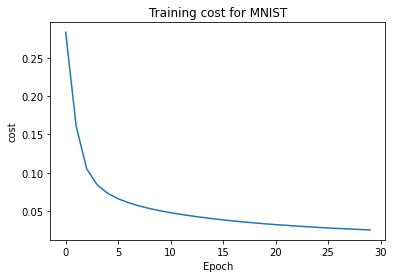

In [ ]:
plt.plot(training_cost_1)
plt.title('Training cost for MNIST')
plt.xlabel('Epoch')
plt.ylabel('cost')